In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import sys 
sys.path.insert(1, "../")
from workloads.util import use_results, use_dataset, read_config, log_dataset, use_plots, log_plots

from tqdm import tqdm
import os

import seaborn as sns
sns.set_theme(style="whitegrid")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
experiment = "ml-1m"
dataset_dir = use_dataset(experiment)
result_dir = use_results(experiment, download=False)

/data/wooders/ralf-vldb//datasets/ml-1m


# Runtime Analysis 

In [ ]:
lines = open(f"{result_dir}/runtimes.txt").read().split("\n")
runtimes = pd.DataFrame({"runtimes": [float(l) for l in lines[:-1]]})

In [ ]:
plt.tight_layout()

f, ax = plt.subplots(ncols=1, figsize=(10, 5))
   
sns.boxplot(x=runtimes["runtimes"])
ax.set(title="Featurization Runtime (Recommendation)", xlabel="Time (s)")
 

In [ ]:
avg_runtime = runtimes.runtimes.mean()
avg_runtime

In [5]:
split = 0.75 
updates_per_ts = [0.5, 0.25, 0.2, 1, 2, 3, 4, 5, 8, 10000, None]
ts_factor = [60] #, 60*60, 60*60*24]
policies = ["total_error_cold", "query_proportional", "max_pending", "min_past", "round_robin", "batch"] #, "last_query"]

In [6]:
limit = None #100000 #100000

In [7]:
stream_df = pd.read_csv(f'{dataset_dir}/stream_{split}.csv')
start_ts = stream_df.timestamp.min()
stream_df.timestamp = stream_df.timestamp.apply(lambda ts: ts - start_ts)
stream_df

,user_id,movie_id,rating,timestamp
0,1,661,3,3081168
1,1,914,3,3081027
2,1,3408,4,3079334
3,1,2355,5,3603350
4,1,1197,3,3081327
...,...,...,...,...
249907,6040,1333,4,22233199
249908,6040,3362,4,22232855
249909,6040,161,3,22233545
249910,6040,2725,4,22233239


# Collect Baselines 

In [8]:
results = []

for baseline in [None, 10000]:
    for t in ts_factor: 

        update_df = pd.read_csv(f"{result_dir}/round_robin_{baseline}_{t}_split_{split}_updates.csv")
        df = pd.read_csv(f"{result_dir}/round_robin_{baseline}_{t}_split_{split}_results.csv")
        print(len(df.index))
        df = df.iloc[:limit]
        
        timestamp = df.timestamp.max()
        update_df = update_df[update_df["time"] < timestamp]

        error = mean_squared_error(df.y_pred, df.y_true)
        total_updates = len(update_df.index)

        if baseline is None:
            results.append([0, error, total_updates, t, df.timestamp.max()])
        else: 
            results.append([baseline, error, total_updates, t, df.timestamp.max()])
        
baseline_results_df = pd.DataFrame(results, columns=["updates", "error", "total_updates", "ts_factor", "max_ts"])
baseline_results_df

249912
249912


,updates,error,total_updates,ts_factor,max_ts
0,0,5.210594,0,60,1187227
1,10000,1.060045,85297,60,1187227


In [9]:
updates_df = pd.DataFrame()
df_all = pd.DataFrame()
results = [] 

for p in policies: 
    for u in updates_per_ts: 
        for t in ts_factor: 
            
            if not os.path.exists(f"{result_dir}/{p}_{u}_{t}_split_{split}_updates.csv"): 
                continue
                
            update_df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_split_{split}_updates.csv")
            df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_split_{split}_results.csv")
            
            
            if limit is not None:
                if len(df.index) <= limit: 
                    print(f"{result_dir}/{p}_{u}_{t}_split_{split}_results.csv")
                    continue 

                # filter time 
                df = df.iloc[:limit]
                timestamp = df.timestamp.max()
                update_df = update_df[update_df["time"] < timestamp]

            print(p, u, t, df.timestamp.max(), update_df["time"].max())
            
            df["policy"] = p
            df["updates"] = u 
            df["ts_factor"] = t
            update_df["updates"] = u 
            update_df["ts_factor"] = t
            
            # threshold predictions 
            df["y_pred"][df["y_pred"] > 5] = 5
            df["y_pred"][df["y_pred"] < 1] = 1
            
            #print(df.y_pred)
            #print(df.y_true)

            error = mean_squared_error(df.y_pred, df.y_true)
            
            #print(update_df.time.value_counts())
            

            total_updates = len(update_df.index)
            print(total_updates, len(df.index), error)
            results.append([u , p, error, total_updates, t, df.timestamp.max()])
            updates_df = pd.concat([updates_df, update_df])
            df_all = pd.concat([df_all, df])
      
results_df = pd.DataFrame(results, columns=["updates", "policy", "error", "total_updates", "ts_factor", "max_ts"])
results_df

total_error_cold 0.5 60 1187227 1187227


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


41928 249912 1.0991756707824303
total_error_cold 0.25 60 1187227 1187225


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


27404 249912 1.1969537324279353
total_error_cold 0.2 60 1187227 1187226


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


24100 249912 1.2369876041073908
total_error_cold 1 60 1187227 1187227
65797 249912 1.065432422173671


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 2 60 1187227 1187227
78046 249912 1.0612137276032347


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 3 60 1187227 1187227
82255 249912 1.0604251834678773


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 4 60 1187227 1187227
84023 249912 1.060293800592213


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 5 60 1187227 1187227
84814 249912 1.060178975177287


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


total_error_cold 8 60 1187227 1187227
85291 249912 1.0600445489198627


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 0.5 60 1187227 1187227
41928 249912 2.5415272902121453


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 0.25 60 1187227 1187225
27404 249912 2.981889669865253


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 0.2 60 1187227 1187226
24100 249912 3.138191990302476


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 1 60 1187227 1187227
65797 249912 2.059058653051571


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 2 60 1187227 1187227
78139 249912 1.3960963175043641


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 3 60 1187227 1187227
82306 249912 1.2017909449332058


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 4 60 1187227 1187227
84037 249912 1.1167416238891041


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 5 60 1187227 1187227
84815 249912 1.0789292951005474


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


query_proportional 8 60 1187227 1187227
85294 249912 1.0600020195653628


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.5 60 1187227 1187227
41928 249912 1.4103429639263578


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.25 60 1187227 1187225
27404 249912 1.7601674484873362


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 0.2 60 1187227 1187226
24100 249912 1.927127733504596


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 1 60 1187227 1187227
65797 249912 1.1981118159009863


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 2 60 1187227 1187227
78123 249912 1.0921415104943677


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 3 60 1187227 1187227
82330 249912 1.068744628489649


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 4 60 1187227 1187227
84059 249912 1.0627008887360054


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 5 60 1187227 1187227
84824 249912 1.0606707293686948


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


max_pending 8 60 1187227 1187227
85295 249912 1.060044555472714


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.5 60 1187227 1187227
41928 249912 1.1109448111996625


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.25 60 1187227 1187225
27404 249912 1.2171668821522077


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 0.2 60 1187227 1187226
24100 249912 1.25494748618772


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 1 60 1187227 1187227
65797 249912 1.0757829197152975


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 2 60 1187227 1187227
78005 249912 1.0633582635069116


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 3 60 1187227 1187227
82215 249912 1.060640237486188


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 4 60 1187227 1187227
84016 249912 1.0602618271688753


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 5 60 1187227 1187227
84792 249912 1.0600492860531447


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


min_past 8 60 1187227 1187227
85292 249912 1.0600445668113283


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.5 60 1187227 1187227
41928 249912 1.4773018440622276


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.25 60 1187227 1187225
27404 249912 2.2485904847688802


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 0.2 60 1187227 1187226
24100 249912 2.6086018974733944


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 1 60 1187227 1187227
65797 249912 1.1887138438639973


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 2 60 1187227 1187227
77680 249912 1.0897742365981418


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 3 60 1187227 1187227
82054 249912 1.0701098171354069


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 4 60 1187227 1187227
83962 249912 1.0649775399798973


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 5 60 1187227 1187227
84782 249912 1.0624432754606334


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 8 60 1187227 1187227
85292 249912 1.0600321080558566


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin 10000 60 1187227 1187227
85298 249912 1.0600445662300224


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


round_robin None 60 1187227 nan
0 249912 5.21059364881312


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


batch 0.5 60 1187227 1185813
32892 249912 1.4929679559526667


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


batch 0.2 60 1187227 1165874
13014 249912 2.740427307094722


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


batch 1 60 1187227 1187227
65797 249912 1.179026936098778


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


batch 2 60 1187227 1187227
76253 249912 1.0903743111290554


/tmp/ipykernel_3092022/1517576027.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] > 5] = 5
/tmp/ipykernel_3092022/1517576027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pred"][df["y_pred"] < 1] = 1


,updates,policy,error,total_updates,ts_factor,max_ts
0,0.50,total_error_cold,1.099176,41928,60,1187227
1,0.25,total_error_cold,1.196954,27404,60,1187227
2,0.20,total_error_cold,1.236988,24100,60,1187227
3,1.00,total_error_cold,1.065432,65797,60,1187227
4,2.00,total_error_cold,1.061214,78046,60,1187227
5,3.00,total_error_cold,1.060425,82255,60,1187227
6,4.00,total_error_cold,1.060294,84023,60,1187227
7,5.00,total_error_cold,1.060179,84814,60,1187227
8,8.00,total_error_cold,1.060045,85291,60,1187227
9,0.50,query_proportional,2.541527,41928,60,1187227


In [11]:
plots_dir = use_plots("ml-1m")
results_df.to_csv(f"{plots_dir}/results.csv")
baseline_results_df.to_csv(f"{plots_dir}/baseline.csv")
log_plots("ml-1m")

{'results_dir': '/data/wooders/ralf-vldb//results', 'dataset_dir': '/data/wooders/ralf-vldb//datasets', 'plots_dir': '/data/wooders/ralf-vldb//plots', 'aws_dir': 'vldb', 'credentials': '/home/eecs/wooders/experiments/ralf-vldb.json'}
uploading /data/wooders/ralf-vldb//plots ml-1m
vldb/plots ml-1m /ml-1m/baseline.csv
uploading /data/wooders/ralf-vldb//plots/ml-1m vldb/plots vldb/plots/ml-1m/baseline.csv
vldb/plots ml-1m /ml-1m/results.csv
uploading /data/wooders/ralf-vldb//plots/ml-1m vldb/plots vldb/plots/ml-1m/results.csv


'vldb/plots/ml-1m'

In [12]:
results_df[results_df["ts_factor"] == 60]

,updates,policy,error,total_updates,ts_factor,max_ts
0,0.50,total_error_cold,1.099176,41928,60,1187227
1,0.25,total_error_cold,1.196954,27404,60,1187227
2,0.20,total_error_cold,1.236988,24100,60,1187227
3,1.00,total_error_cold,1.065432,65797,60,1187227
4,2.00,total_error_cold,1.061214,78046,60,1187227
5,3.00,total_error_cold,1.060425,82255,60,1187227
6,4.00,total_error_cold,1.060294,84023,60,1187227
7,5.00,total_error_cold,1.060179,84814,60,1187227
8,8.00,total_error_cold,1.060045,85291,60,1187227
9,0.50,query_proportional,2.541527,41928,60,1187227


In [13]:
def plot_factor_total_updates(ts_factor_filter, subset, log=False):

    f, ax = plt.subplots(ncols=1, figsize=(8, 5))
    plt.tight_layout()
    sns.set_theme(style="whitegrid", font_scale=1.7)
    #ts_factor_filter = 60

    plot_df = results_df[(results_df["ts_factor"] == ts_factor_filter) & (results_df.policy.isin(subset))]
    plot_df.policy = plot_df.policy.map({
        'total_error_cold': 'Regret Optimized', 
        'min_past': 'Minumum Past', 
        'round_robin': "Round-Robin", 
        'max_pending': "Maximum Pending Updates", 
        'last_query': "Read-Optimized", 
        "query_proportional": "Query Proportional",
        "batch": "Batched"
    })
    
    plot_df = plot_df.dropna()
    
    if log: 
        plot_df.error = np.log2(plot_df.error)
        
    sns.lineplot(x="total_updates", y="error", hue="policy", data=plot_df, ax=ax, linewidth=3)
    #ax.set(title="Prediction Accuracy per Policy (Recommendation)", xlabel="Total Featurization Updates",  ylabel="MSE")
    
    if log: 
        ax.set(title="", xlabel="Total Featurization Updates",  ylabel="Log2 MSE")
    else:
        ax.set(title="", xlabel="Total Featurization Updates",  ylabel="MSE")
    ax.set(xscale="log")
    
    upper_bound = baseline_results_df[(baseline_results_df["updates"] == 10000) & (baseline_results_df["ts_factor"] == ts_factor_filter)].error.iloc[0]
    upper_bound_updates = baseline_results_df[(baseline_results_df["updates"] == 10000) & (baseline_results_df["ts_factor"] == ts_factor_filter)].total_updates.iloc[0]
    lower_bound = baseline_results_df[(baseline_results_df["updates"] == 0) & (baseline_results_df["ts_factor"] == ts_factor_filter)].error.iloc[0]
    lower_bound_updates = baseline_results_df[(baseline_results_df["updates"] == 0) & (baseline_results_df["ts_factor"] == ts_factor_filter)].total_updates.iloc[0]
    print(upper_bound, upper_bound_updates)
    
    return plt
    
    if log: 
        plt.axline((0, np.log2(upper_bound)), (1, np.log2(upper_bound)), color='black', linestyle="--")
    else:
        plt.axline((0, upper_bound), (1, upper_bound), color='black', linestyle="--")
        
    plt.axvline(upper_bound_updates, color='black', linestyle="--")
    
    #plt.axline((0, lower_bound), (1, lower_bound), color='black', linestyle="--")
    #plt.axvline(lower_bound_updates, linewidth=3, color='black', linestyle="--")
    #plt.legend(loc='upper right')
    
    #plt.scatter(upper_bound_updates, upper_bound, marker='o', s=100)
    #plt.scatter(lower_bound_updates, lower_bound, marker='o', s=100)
    
    return plt
    


In [14]:
def plot_factor(ts_factor_filter, subset, updates):

    f, ax = plt.subplots(ncols=1, figsize=(8, 5))
    plt.tight_layout()
    sns.set_theme(style="whitegrid", font_scale=1.7)
    #ts_factor_filter = 60

    plot_df = results_df[(results_df["ts_factor"] == ts_factor_filter) & (results_df.policy.isin(subset)) & (results_df.updates.isin(updates))]
    plot_df.policy = plot_df.policy.map({
        'total_error_cold': 'Regret Optimized', 
        'min_past': 'Minimum Past', 
        'round_robin': "Round-Robin", 
        'max_pending': "Maximum Pending Updates", 
        'last_query': "Read-Optimized", 
        "query_proportional": "Query Proportional",
        "batch": "Batched"
    })
    plot_df = plot_df.dropna()
    print(plot_df)
    sns.barplot(x="updates", y="error", hue="policy", data=plot_df, log=False, ax=ax)
    #ax.set(title="Prediction Error per Policy (Recommendation)", xlabel="Budget (Updates per Timestep)",  ylabel="Log MSE")
    
    ax.set(title="", xlabel="Budget (Updates per Timestep)",  ylabel="Log MSE")
    
    upper_bound = baseline_results_df[(baseline_results_df["updates"] == 10000) & (baseline_results_df["ts_factor"] == ts_factor_filter)].error.iloc[0]
    lower_bound = baseline_results_df[(baseline_results_df["updates"] == 0) & (baseline_results_df["ts_factor"] == ts_factor_filter)].error.iloc[0]

    #plt.axline((0, lower_bound), (1, lower_bound), color='r')
    plt.axline((0, upper_bound), (1, upper_bound), linewidth=3, color='g')
    
    margin = (plot_df.error.max() - upper_bound)/10
    plt.ylim([upper_bound - margin, plot_df.error.max() + margin])
    
    return plt 
    
    

/tmp/ipykernel_3092022/3053104037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.policy = plot_df.policy.map({


    updates            policy     error  total_updates  ts_factor   max_ts
0       0.5  Regret Optimized  1.099176          41928         60  1187227
3       1.0  Regret Optimized  1.065432          65797         60  1187227
4       2.0  Regret Optimized  1.061214          78046         60  1187227
27      0.5      Minimum Past  1.110945          41928         60  1187227
30      1.0      Minimum Past  1.075783          65797         60  1187227
31      2.0      Minimum Past  1.063358          78005         60  1187227


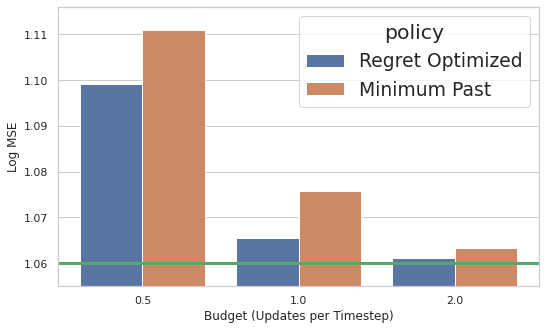

In [15]:
#subset = ["total_error_cold", "min_past", "round_robin", "max_pending", "last_query", "query_proportional", "batch"]
subset = ["total_error_cold", "min_past"]

plt = plot_factor(60, subset, updates=[0.5, 1, 2])
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_bar_1.pdf') 

In [ ]:
subset = ["total_error_cold", "min_past"]

plot_factor(60, subset, updates=[1, 2, 3, 4, 6, 8])
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_bar_2.pdf') 

In [ ]:
subset = ["total_error_cold", "min_past", "round_robin", "max_pending", "last_query", "query_proportional", "batch"]

plt = plot_factor(60, subset, updates=[0.5, 1, 2, 3, 4, 6, 8])
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_bar_all.pdf') 

In [ ]:
subset = ["total_error_cold", "min_past"] #, "round_robin", "max_pending", "last_query", "query_proportional", "batch"]

plt = plot_factor_total_updates(60, subset, log=False)
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_line.pdf') 

In [ ]:
subset = ["total_error_cold", "min_past", "round_robin", "max_pending", "last_query", "query_proportional", "batch"]

plt = plot_factor_total_updates(60, subset, log=False)
plt.tight_layout()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_line_all.pdf') 

## Plot Rate of Updates vs. Error Improvement 

In [ ]:
window_size = 1 
ts_factor = 60

In [ ]:
stream_df["adj_timestamp"] = stream_df["timestamp"].apply(lambda x: int(x/60))
start_ts = stream_df.adj_timestamp.min()
end_ts = stream_df.adj_timestamp.max()

print(start_ts, end_ts)

In [ ]:
count_df = stream_df.groupby("adj_timestamp").user_id.nunique().to_frame()

In [ ]:
count_df = stream_df.groupby("adj_timestamp").user_id.nunique().to_frame()
time_df = pd.Series(range(start_ts, end_ts, 1)).to_frame("timestamp").merge(count_df, how="left", left_on="timestamp", right_on="adj_timestamp").fillna(0)
user_update_rate_df = time_df.user_id.rolling(window_size).sum()

In [ ]:
user_update_rate_df.plot()

In [ ]:
count_df = stream_df.groupby("adj_timestamp").user_id.count().to_frame()
time_df = pd.Series(range(start_ts, end_ts, 1)).to_frame("timestamp").merge(count_df, how="left", left_on="timestamp", right_on="adj_timestamp").fillna(0)

rating_update_rate_df = pd.DataFrame()
rating_update_rate_df["n"] = time_df.user_id.rolling(window_size).sum()
rating_update_rate_df["timestamp"] = time_df.timestamp.rolling(window_size).max().fillna(0)

In [ ]:
rating_update_rate_df.n.plot()

In [ ]:
eval_df = df_all[df_all["ts_factor"] == ts_factor]
eval_df["error_diff"] = (eval_df["y_pred"] - eval_df["y_true"]).pow(2)
eval_df

In [ ]:
eval_df = df_all[df_all["ts_factor"] == ts_factor]
eval_df["error_diff"] = (eval_df["y_pred"] - eval_df["y_true"]).pow(2)

records = []
for (updates, policy, ts), group in tqdm(eval_df.groupby(["updates", "policy", "timestamp"])): 
    records.append({
        "updates": updates, 
        "policy": policy, 
        "timestamp": ts, 
        "error": group.error_diff.mean()
    })

    
    
print("finished group")
ts_error_df = pd.DataFrame(records)
print(ts_error_df)

In [ ]:
ts_error_df.to_csv(f"{result_dir}/error_time_{ts_factor}.csv")

In [ ]:
error_window_df = ts_error_df.reset_index()

In [ ]:
min_past_df = error_window_df[error_window_df["policy"] == "min_past"].groupby(["updates", "timestamp"]).error.min().to_frame().reset_index()
max_pending_df = error_window_df[error_window_df["policy"] == "max_pending"].groupby(["updates", "timestamp"]).error.min().to_frame().reset_index()
optimized_df = error_window_df[error_window_df["policy"] == "total_error_cold"].groupby(["updates", "timestamp"]).error.min().to_frame().reset_index()

In [ ]:
updates = 0.2

improvement_min_past = min_past_df[min_past_df["updates"] == updates].error - optimized_df[optimized_df["updates"] == updates].error
improvement_max_pending = max_pending_df[max_pending_df["updates"] == updates].error - optimized_df[optimized_df["updates"] == updates].error

In [ ]:
total_counts = []
for ts in tqdm(baseline_df[baseline_df["updates"] == updates].timestamp.tolist()):
    if ts >= 60: 
        total_count = time_df[(time_df["timestamp"] > ts - 60) & (time_df["timestamp"] <= ts)].user_id.unique().sum()
        total_counts.append(total_count)
        
    if len(total_counts) >= 100000:
        break

In [ ]:
improvement

In [ ]:
min_past_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_min_past.rolling(60).mean().tolist()[58:], "policy": "Minimum Past"})
max_pending_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_max_pending.rolling(60).mean().tolist()[58:], "policy": "Maximum Pending"})

plot_df = pd.concat([min_past_df, max_pending_df])
plot_df

In [ ]:
plt.tight_layout()

g=sns.lmplot(x="update_rate", y="improvement", hue="policy", data=plot_df, order=2, scatter=False, legend=False, height=5, aspect=1.5)

g.set(title="Improvement (Recommendation)", xlabel="Hourly Unique User Ratings",  ylabel="MSE")

g.despine(left=True)
plt.legend(loc='lower center')

results_df.to_csv(f"/data/wooders/ralf-vldb/plots/als_improvements.csv")
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_improvement_rate.pdf')

In [ ]:
plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_max_pending.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2, scatter=False)

In [ ]:
plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_min_past.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2, scatter=False)

In [ ]:
f, ax = plt.subplots(ncols=1, figsize=(5, 5))
plt.tight_layout()

plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_max_pending.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2, scatter=False, ax=ax, label="Max Pending", x_bins=100)

ax.set(title="Mean Improvement per Hour", xlabel="Unique Users per Hour",  ylabel="MSE")
ax.legend()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_improvement_max_pending.pdf')

In [ ]:
f, ax = plt.subplots(ncols=1, figsize=(5, 5))
plt.tight_layout()

plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_min_past.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2, scatter=False, ax=ax, label="Max Pending", x_bins=100)

ax.set(title="Mean Improvement per Hour", xlabel="Unique Users per Hour",  ylabel="MSE")
ax.legend()
plt.savefig('/data/wooders/ralf-vldb/plots/als_1m_improvement_min_past.pdf')

In [ ]:
f, ax = plt.subplots(ncols=1, figsize=(5, 5))
plt.tight_layout()

plot_df = pd.DataFrame({"update_rate": total_counts, "improvement": improvement_min_past.rolling(60).mean().tolist()[58:]})

sns.regplot(x="update_rate", y="improvement", data=plot_df, order=6, scatter=False, ax=ax, label="Minimum Past")

ax.set(title="Mean Improvement per Hour", xlabel="Unique Users per Hour",  ylabel="MSE")
ax.legend()

In [ ]:
plot_df = pd.DataFrame({ 
    #"timestamp": rating_update_rate_df.iloc[:1000].timestamp, 
    "update_rate":  rating_update_rate_df.iloc[:100000].n,
    "improvement": improvement.iloc[:100000]
})
plot_df = pd.DataFrame({
    "update_rate": plot_df.groupby("update_rate").groups.keys(), 
    "improvement": plot_df.groupby("update_rate").improvement.mean()
})


sns.regplot(x="update_rate", y="improvement", data=plot_df, order=2)

In [ ]:
sns.scatterplot(x="update_rate", y="improvement", data=plot_df)

In [ ]:
plot_df.groupby("update_rate").groups.keys()

In [ ]:
plot_df = pd.DataFrame({ 
    "timestamp": rating_update_rate_df.iloc[window_size:10000+window_size].timestamp, 
    "update_rate":  rating_update_rate_df.iloc[window_size:10000+window_size].n,
    "improvement": improvement.iloc[0:10000]
})

sns.regplot(x="update_rate", y="improvement", data=plot_df)

In [ ]:
optimized_df[optimized_df["updates"] == 0.2].iloc[:1000].error.mean()

In [ ]:
baseline_df[baseline_df["updates"] == 0.2].iloc[:1000].error.mean()

In [ ]:
error_window_df[(error_window_df["updates"] == 0.2) & (error_window_df["policy"] == "total_error_cold")].error.plot()

In [ ]:
error_window_df

In [ ]:
error_window_df = eval_df.groupby(["policy", "updates"]) \
    .apply(lambda x: x.error_diff.rolling(window_size).sum())#lambda x: mean_absolute_error(x.y_pred, x.y_true)*x.y_pred.count() if x.y_pred.count() > 0 else 0)

In [ ]:
error_window_df = error_window_df.reset_index()

In [ ]:
error_window_df

In [ ]:
optimized_window_error = error_window_df[error_window_df["policy"] == "total_error_cold"]
optimized_window_error

In [ ]:
baseline_window_error = error_window_df[error_window_df["policy"] != "total_error_cold"].groupby("updates").apply(lambda x: x.iloc[:, 2:].min()).reset_index()
baseline_window_error

In [ ]:
updates = 0.2

baseline = (baseline_window_error[baseline_window_error["updates"] == updates].iloc[0, 1:]).to_list()
optimized = (optimized_window_error[optimized_window_error["updates"] == updates].iloc[0, 2:]).to_list()

improvement_df = pd.DataFrame({"baseline": baseline, "optimized": optimized})
improvement_df["improvement"] = improvement_df["baseline"] - improvement_df["optimized"]
improvement_df

In [ ]:
improvement_df.improvement.plot()

In [ ]:
eval_df = df_all[df_all["ts_factor"] == ts_factor]
error_dfs = []
improvement_df = []
for t in tqdm(range(start_ts, end_ts, window_size)): 
    eval_t_df = eval_df[(eval_df["timestamp"] >= t) & (eval_df["timestamp"] < t+window_size)]
    
    if len(eval_t_df.index) == 0: continue
    
    group_df = eval_t_df.groupby(["policy", "updates"])
    error_t_df = group_df.apply(lambda x: mean_absolute_error(x.y_pred, x.y_true)*x.y_pred.count() if x.y_pred.count() > 0 else 0)
    #error_t_df = group_df.apply(lambda x: mean_absolute_error(x.y_pred, x.y_true) if x.y_pred.count() > 0 else 0)

    error_t_df = error_t_df.reset_index(name="error")
    error_t_df["timestamp_idx"] = int(t/window_size)
    error_dfs.append(error_t_df)
    
    
    impr_df = pd.DataFrame()
    impr_df["baseline"] = error_t_df[error_t_df["policy"] != "total_error_cold"].groupby("updates").error.min()
    impr_df["regret_optimized"] = error_t_df[error_t_df["policy"] == "total_error_cold"].groupby("updates").error.min()
    impr_df["timestamp_hr"] = int(t/60)
    impr_df["timestamp"] = t+60
    improvement_df.append(impr_df)
    
    
    

error_df = pd.concat(error_dfs)
improvement_df = pd.concat(improvement_df)
error_df

In [ ]:
u_df = updates_df[(updates_df["ts_factor"] == 60) &(updates_df["policy"] == "round_robin")]

In [ ]:
ts_factor = 60
single_update_df = updates_df[(updates_df["ts_factor"] == 60) &(updates_df["policy"] == "round_robin")]
single_update_df = single_update_df.groupby("time").runtime.count().reset_index()
stream_df["adj_timestamp"] = stream_df["timestamp"].apply(lambda x: int(x/60))
all_update_df = pd.DataFrame()
all_update_df["user_updates"] = stream_df.groupby("adj_timestamp").user_id.nunique()
all_update_df["rating_updates"] = stream_df.groupby("adj_timestamp").user_id.count()
print(all_update_df)
print(single_update_df)

In [ ]:
update_time_df = all_update_df.merge(single_update_df, how="left", left_on="adj_timestamp", right_on="time")
print(update_time_df)
update_time_df = update_time_df[["time", "user_updates", "rating_updates", "runtime"]]
update_time_df.columns = ["timestamp", "user_updates", "rating_updates", "updates"]
update_time_df

In [ ]:

sns.scatterplot(x='timestamp', y='rating_updates', data=update_time_df[update_time_df["timestamp"] < 10000])
sns.scatterplot(x='timestamp', y='user_updates', data=update_time_df[update_time_df["timestamp"] < 10000])

In [ ]:
plt.tight_layout()
f, ax = plt.subplots(ncols=1, figsize=(10, 5))
sns.set_theme(style="whitegrid", font_scale=1.7)

sns.regplot(x='timestamp', y='rating_updates', data=update_time_df[update_time_df["timestamp"] < 10000], order=10, label="Number Ratings", x_bins=20, ax=ax)
sns.regplot(x='timestamp', y='user_updates', data=update_time_df[update_time_df["timestamp"] < 10000], order=10, label="Number Unique Users", x_bins=100, ax=ax)

ax.set(title="Incoming Data Rate per Minute (Recommendation)", xlabel="Timestep (minutes)",  ylabel="Count")
ax.legend()

In [ ]:
plt.tight_layout()
f, ax = plt.subplots(ncols=1, figsize=(10, 5))
sns.set_theme(style="whitegrid", font_scale=1.7)

sns.scatterplot(x='timestamp', y='rating_updates', data=update_time_df[update_time_df["timestamp"] < 10000], label="Number Ratings", ax=ax)
sns.scatterplot(x='timestamp', y='user_updates', data=update_time_df[update_time_df["timestamp"] < 10000], label="Number Unique Users", ax=ax)

ax.set(title="Incoming Data Rate per Minute (Recommendation)", xlabel="Timestep (minutes)",  ylabel="Count")
ax.legend()

In [ ]:
df_all

In [ ]:
df_all

In [ ]:
eval_df = df_all[df_all["ts_factor"] == 60]
error_dfs = []
improvement_df = []
for t in tqdm(range(0, 10000, 60)): 
    eval_t_df = eval_df[(eval_df["timestamp"] >= t) & (eval_df["timestamp"] < t+60)]
    
    if len(eval_t_df.index) == 0: continue
    
    group_df = eval_t_df.groupby(["policy", "updates"])
    error_t_df = group_df.apply(lambda x: mean_absolute_error(x.y_pred, x.y_true)*x.y_pred.count() if x.y_pred.count() > 0 else 0)
    #error_t_df = group_df.apply(lambda x: mean_absolute_error(x.y_pred, x.y_true) if x.y_pred.count() > 0 else 0)

    error_t_df = error_t_df.reset_index(name="error")
    error_t_df["timestamp_hr"] = t/60
    error_dfs.append(error_t_df)
    
    
    impr_df = pd.DataFrame()
    impr_df["baseline"] = error_t_df[error_t_df["policy"] != "total_error_cold"].groupby("updates").error.min()
    impr_df["regret_optimized"] = error_t_df[error_t_df["policy"] == "total_error_cold"].groupby("updates").error.min()
    impr_df["timestamp_hr"] = int(t/60)
    impr_df["timestamp"] = t+60
    improvement_df.append(impr_df)
    
    
    

error_df = pd.concat(error_dfs)
improvement_df = pd.concat(improvement_df)
error_df

In [ ]:
improvement_df = improvement_df.reset_index()

In [ ]:
improvement_df["total_error_change"] = improvement_df["baseline"] - improvement_df["regret_optimized"]

In [ ]:
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.7)
plot_df = improvement_df
plot_df["total_error_change"] = improvement_df["baseline"] - improvement_df["regret_optimized"]
plot_df["Updates per Hour"] = (plot_df["updates"] * 60).astype(int)
ax = sns.lmplot(x="timestamp", y="total_error_change", hue="Updates per Hour", col="Updates per Hour", col_wrap=2, order=10, data=plot_df)
ax.set(xlabel="Timestep (minutes)",  ylabel="Total Error", ylim=(-30, 60))

ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle("Hourly Total Error Improvement (Recommendation)")

In [ ]:
df = improvement_df.merge(update_time_df, how="left", on=["timestamp", "updates"])

In [ ]:
df.rating_updates.value_counts()

In [ ]:
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.7)
ax = sns.regplot(x="timestamp", y="total_error_change", order=10, data=improvement_df)
ax.set(title="Total Error Improvement per Hour (Recommendation)", xlabel="Timestep (minutes)",  ylabel="Total Error")

In [ ]:
improvement_df[improvement_df["total_error_change"] < -100]

In [ ]:
sns.scatterplot(x='timestamp', y='ratings', data=update_time_df[update_time_df["timestamp"] < 10000])
sns.scatterplot(x='timestamp', y='updates', data=update_time_df[update_time_df["timestamp"] < 10000])

In [ ]:
sns.regplot(x='timestamp', y='ratings', data=update_time_df[update_time_df["timestamp"] < 10000], order=10)

In [ ]:
update_time_df["timestamp_hr"] = update_time_df["timestamp"].apply(lambda x: int(x/60))
update_agg_df = update_time_df.groupby("timestamp_hr").ratings.sum().reset_index(name="user_updates")
print(update_agg_df)
sns.lineplot(x='timestamp', y='user_updates', data=update_agg_df[update_agg_df["timestamp_hr"] < 160])

In [ ]:
diff_df = error_df[error_df["policy"] != "total_error_cold"]
diff_df = diff_df.merge(error_df[error_df["policy"] == "total_error_cold"], how="left", on="timestamp", suffixes=('', '_baseline')).reset_index()
diff_df["error_improvement"] = diff_df["error"] - diff_df["error_baseline"]
sns.lineplot(x="timestamp", y="error_improvement", hue="policy", data=diff_df)

In [ ]:
#f, ax = plt.subplots(ncols=1, figsize=(10, 5))
plt.tight_layout()
#sns.set_theme(style="whitegrid", font_scale=1.7)
ts_factor_filter = 60

subset = ["total_error_cold", "min_past", "round_robin", "max_pending"]
#subset = ["total_error_cold", "min_past", "max_pending"]

diff_df = error_df[error_df["policy"] != "total_error_cold"]
diff_df = diff_df.merge(error_df[error_df["policy"] == "total_error_cold"], how="left", on="timestamp_hr", suffixes=('', '_baseline')).reset_index()
diff_df["error_improvement"] = diff_df["error"] - diff_df["error_baseline"]

plot_df = diff_df[diff_df.policy.isin(subset)]
plot_df.policy = plot_df.policy.map({
    'total_error_cold': 'Regret Optimized', 
    'min_past': 'Minimum Past Updates', 
    'round_robin': "Round-Robin", 
    'max_pending': "Maximum Pending Updates", 
    'last_query': "Read-Optimized", 
    "query_proportional": "Query Proportional",
    "batch": "Batched"
})
#sns.scatterplot(x="timestamp_hr", y="error_improvement", hue="policy", data=plot_df, ax=ax)
g = sns.lmplot(x="timestamp_hr", y="error_improvement", hue="policy", aspect=2, data=plot_df, order=10)
#g.set(ylim=(-1000, 6000))
ax.set(title="Total Error Improvement per Hour (Recommendation)", xlabel="Timestep (hours)",  ylabel="Total Squared Error")

In [ ]:
data_df = error_df[(error_df["policy"] == "total_error_cold") | (error_df["policy"] == "min_past")].reset_index()
data_df["error"] = np.log(data_df["error"])
sns.lineplot(x="timestamp", y="error", hue="policy", data=data_df)

In [ ]:
data_df = error_df[(error_df["policy"] == "total_error_cold") | (error_df["policy"] == "query_proportional")].reset_index()
data_df["error"] = np.log(data_df["error"])
sns.lineplot(x="timestamp", y="error", hue="policy", data=data_df)

In [ ]:
f, ax = plt.subplots(ncols=2, figsize=(10, 5))
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.2)
ts_factor = 10 

plot_df = results_df[(results_df["ts_factor"] == 10) & (results_df.policy.isin(["total_error_cold", "min_past", "round_robin", "max_pending", "last_query"]))]
plot_df.policy = plot_df.policy.map({
    'total_error_cold': 'Regret Optimized', 
    'min_past': 'Minimum Past Updates', 
    'round_robin': "Round-Robin", 
    'max_pending': "Maximum Pending Updates", 
    'last_query': "Read-Optimized"
})
plot_df = plot_df.dropna()
sns.barplot(x="updates", y="error", hue="policy", data=plot_df, log=True, ax=ax[0])

plot_df = plot_df[plot_df.policy.isin(['Minimum Past Updates', 'Regret Optimized'])].reset_index()
print(plot_df)
sns.barplot(x="updates", y="error", hue="policy", data=plot_df, log=True, ax=ax[1])

ax[1].set(title="Prediction Accuracy per Policy (Recommendation)", xlabel="Updates per Timestep",  ylabel="Log MSE")
ax[1].set(title="Prediction Accuracy per Policy (Recommendation)", xlabel="Updates per Timestep",  ylabel="MSE")
#plt.legend(np.flip(plot_df['policy'].unique()), loc='upper right', title="Event Type")

In [ ]:
ax = sns.barplot(x="updates", y="error", hue="policy", data=results_df[results_df["ts_factor"] == 10], log=True)

In [ ]:
updates_df.key.value_counts()

In [ ]:
updates_df[(updates_df["time"] > ts_min) & (updates_df["time"] < ts_max) & (updates_df["updates"] == updates) & (updates_df["ts_factor"] == 10)].key.value_counts()

In [ ]:
df_all[(df_all.index > ts_min) & (df_all.index < ts_max) & (df_all["updates"] == updates) & (df_all["ts_factor"] == 10)].user_id.value_counts()

In [ ]:
updates_df

In [ ]:
ts_min = 35000
ts_max = 40000
updates=1

In [ ]:
df_all[(df_all["updates"] == updates) & (df_all["ts_factor"] == 10)].groupby("timestamp").updates.count().plot()


In [ ]:
hist_df = updates_df[(updates_df["time"] > ts_min) & (updates_df["time"] < ts_max) & (updates_df["updates"] == updates) & (updates_df["ts_factor"] == 10)].groupby(by=["key", "policy"]).updates.count().reset_index()
hist_df["user_id"] = hist_df["key"]
hist_df["policy"] = hist_df.policy.map({
    'total_error_cold': 'Accuracy Optimized', 
    'min_past': 'Minimum Past Updates', 
    'round_robin': "Round Robin", 
    'max_pending': "Maximum Pending"
})
hist_df = hist_df.dropna()
hist_df.user_id.value_counts()

samples_df = df_all[(df_all["timestamp"] > ts_min) & (df_all.index < ts_max) & (df_all["updates"] == updates) & (df_all["ts_factor"] == 10)]\
    .groupby(by=["user_id", "policy"])\
    .ts_factor.count()\
    .to_frame(name="samples")\
    .reset_index()

In [ ]:
# samples_df = df_all[(df_all.index > ts_min) & (df_all.index < ts_max) & (df_all["updates"] == updates) & (df_all["ts_factor"] == 10)].groupby(by=["user_id", "policy"]).ts_factor.count().to_frame(name="samples")
# ratio_df = pd.DataFrame(samples_df).join(hist_df.set_index(["user_id", "policy"]), on=["user_id", "policy"]).reset_index()
# hist_df = updates_df[(updates_df["time"] > ts_min) & (updates_df["time"] < ts_max) & (updates_df["updates"] == updates) & (updates_df["ts_factor"] == 10)].groupby(by=["key", "policy"]).updates.count().reset_index()
# hist_df["user_id"] = hist_df["key"]
# print(ratio_df)
# ratio_df["policy"] = ratio_df.policy.map({
#     'total_error_cold': 'Accuracy Optimized', 
#     'min_past': 'Minimum Past Updates', 
#     'round_robin': "Round Robin", 
#     'max_pending': "Maximum Pending"
# })
# ratio_df = ratio_df.dropna().reset_index()
# ratio_df["ratio"] = ratio_df.apply(lambda x: x["updates"]/x["samples"], axis=1)

# sns.set_theme(style="whitegrid", font_scale=1.5)
# g = sns.histplot(data=ratio_df, x="updates", hue="policy", discrete=False)
# g.set(title="Distribution of Updates Across Keys", xlabel="Scheduled Updates per Key",  ylabel="Number Keys")

In [ ]:
heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=False).fillna(0)
heat_df

In [ ]:
heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=False).fillna(0)
f, ax = plt.subplots(figsize=(10, 5))
plt.tight_layout()
sns.set_theme(style="whitegrid", font_scale=1.7)

sns.heatmap(
    heat_df.iloc[:, :20], 
    annot=True, 
    cbar=False,  
    yticklabels=["Regret Optimized", "Maximum Pending", "Minimum Past", "Round Robin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax
)
ax.set_xlabel(f"Most Updated Users (Timestamps {ts_min}-{ts_max})")
ax.set_ylabel(None)
ax.set_title("Number of Featurization Updates")
#plt.legend(fontsize='x-large')
f.savefig('/data/wooders/ralf-vldb/plots/als_heatmap.pdf', dpi=300, bbox_inches = "tight")

In [ ]:
heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=False).fillna(0)
f, ax = plt.subplots(nrows=2, figsize=(20, 10))
sns.heatmap(
    heat_df.iloc[:, :20], 
    annot=True, 
    cbar=False,  
    #yticklabels=["Regret Optimized", "Minimum Past", "Round Robin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax[0]
)
ax[0].set_xlabel("Most Updated Users")
ax[0].set_ylabel(None)
ax[0].set_title("Featurization Updates")

users = heat_df.columns[1:21]
print(users)
samples = [samples_df[samples_df["user_id"] == u].samples.max() for u in users]
d = pd.DataFrame({"User": range(1, 21, 1), "Raw Data Updates": samples})
print(d)
#d = pd.DataFrame([samples], columns=users, index=["Total Data Points"])
sns.barplot(data=d, x="User", y="Raw Data Updates", ax=ax[1])
#ax[1].set_ylabel(None)
#ax[1].set_title("Raw Data Updates Updates")

In [ ]:
key_df = updates_df[(updates_df["key"] == 2693) & (updates_df["ts_factor"] == 10) & (updates_df["updates"] == 1)]
key_df = key_df.set_index(["time", "policy"]).reset_index()
sns.histplot(key_df, x="time", hue="policy")

In [ ]:
for (i, (key, group)) in enumerate(key_df.groupby("policy")):
    group = group.time.tolist()
    x = group
    y = range(1, len(group) + 1, 1)
    plt.plot(x, y, label=key)
plt.legend()
    

In [ ]:
samples_df[samples_df["user_id"] == 3437]

In [ ]:
heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=False).fillna(0)
f, ax = plt.subplots(nrows=2, figsize=(20, 10))
sns.heatmap(
    heat_df.iloc[:, :20], 
    annot=True,
    cbar=False,  
    #yticklabels=["Regret Optimized", "Minimum Past", "Round Robin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax[0]
)
ax[0].set_xlabel("Most Updated Users")
ax[0].set_ylabel(None)
ax[0].set_title("Featurization Updates")

heat_df = hist_df.pivot("policy", "user_id", "updates").sort_values("Round Robin", axis=1, ascending=True).fillna(0)
sns.heatmap(
    heat_df.iloc[:, :20], 
    annot=True, 
    cbar=False,  
    #yticklabels=["Regret Optimized", "Minimum Past", "Round Robin"],
    xticklabels=range(1, 21, 1),
    square=True,
    ax=ax[1]
)
ax[1].set_xlabel("Least Updated Users")
ax[1].set_ylabel(None)
ax[1].set_title("Featurization Updates")

In [ ]:
users = heat_df.columns[1:21]
samples = [ratio_df[ratio_df["user_id"] == u].samples.max() for u in users]
d = pd.DataFrame({"User": range(1, 21, 1), "Raw Data Updates": samples})
print(d)
#d = pd.DataFrame([samples], columns=users, index=["Total Data Points"])
sns.barplot(data=d, x="User", y="Raw Data Updates")

In [ ]:
#f, ax = plt.subplots(figsize=(20, 2))

#fig, axs = plt.subplots(2, figsize=(20, 6))
fig, axs = plt.subplots(nrows=3)

fig.suptitle('Vertically stacked subplots')

heat_df = ratio_df.pivot("policy", "user_id", "ratio").fillna(0)
sns.heatmap(heat_df.iloc[:, :10], ax=axs[0]) #, square=True, annot=True, cbar=False)

heat_df = ratio_df.pivot("policy", "user_id", "updates").sort_values("Accuracy Optimized", axis=1, ascending=False).fillna(0)
sns.heatmap(heat_df.iloc[:, :10], ax=axs[1], annot=True)

heat_df = ratio_df.pivot("policy", "user_id", "samples").fillna(0)
sns.heatmap(heat_df.iloc[:, :10], ax=axs[2])


In [ ]:
runtime = 1.0
sns.set(rc={'figure.figsize':(10.7,5.27)})
hist_df = updates_df[updates_df["runtime"] == runtime].groupby(by=["key", "policy"]).size()
hist_df = hist_df / samples_df
print(hist_df.max())
hist_df = hist_df.to_frame(name="updates").reset_index()
print(hist_df.policy.value_counts())
hist_df["policy"] = hist_df.policy.map({'total_error_cold': 'Accuracy Optimized', 'min_past': 'Minimum Past Updates', 'round_robin': "Round Robin"})
hist_df = hist_df.dropna()
print(hist_df.max())

sns.set_theme(style="whitegrid", font_scale=1.5)
g = sns.histplot(data=hist_df, x="updates", hue="policy", log_scale=(False, True), discrete=False, bins=30)
g.set(title="Distribution of Updates Across Keys", xlabel="Scheduled Updates per Key",  ylabel="Number Keys")

In [ ]:
updates_df[(updates_df["policy"] == "total_error") & (updates_df["runtime"] == 1.00)]

# Plot Dataset

In [ ]:
factor = 100

In [ ]:
test_df = pd.read_csv(f'{dataset_dir}/stream.csv')
train_df = pd.read_csv(f'{dataset_dir}/train.csv')
start_ts = test_df.timestamp.min()
past_updates = pickle.load(open(f"{result_dir}/past_updates.pkl", "rb"))
test_df.timestamp = test_df.timestamp.apply(lambda ts: int((ts - start_ts)/factor))

In [ ]:
new_user_df = test_df[test_df.user_id.isin(past_updates.keys())]
old_user_df = test_df[~test_df.user_id.isin(past_updates.keys())]

In [ ]:
old_user_df.groupby(by="timestamp").user_id.nunique().plot(label="old_user").legend()
new_user_df.groupby(by="timestamp").user_id.nunique().plot(label="new_user").legend()

In [ ]:
old_user_df.groupby(by="timestamp").rating.count().rolling(1000).mean().plot(label="old_user")
new_user_df.groupby(by="timestamp").rating.count().rolling(1000).mean().plot(label="new_user").legend()

In [ ]:
test_df.groupby(by="timestamp").count().rolling(window=100).mean().plot()

In [ ]:
train_df.movie_id.value_counts()

In [ ]:
test_df.movie_id.value_counts()

# Results Over Time 

In [ ]:
results[0]

In [ ]:
x0 = 0 #190000#test_df.timestamp.min()
x1 = 200000 #test_df.timestamp.max()

p = "min_past"
u = 1
t = 100
df = df_all[(df_all["policy"] == p) & (df_all["ts_factor"] == t) & (df_all["updates"] == u)]
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
print(df.square_error.mean())
df[(df["timestamp"] < x1) & (df["timestamp"] > x0)].groupby(by="timestamp").square_error.sum().plot(label=p) #rolling(1000).mean().plot(xlim=(x0, x1), label=p)
min_past_df = df

p = "total_error_cold"
df = df_all[(df_all["policy"] == p) & (df_all["ts_factor"] == t) & (df_all["updates"] == u)]
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
print(df.square_error.mean())
df[(df["timestamp"] < x1) & (df["timestamp"] > x0)].groupby(by="timestamp").square_error.sum().plot(label=p).legend() #rolling(1000).mean().plot(xlim=(x0, x1), label=p)
total_error_df = df
#p = "total_error"
#df = df_all[(df_all["policy"] == p) & (df_all["ts_factor"] == t) & (df_all["updates"] == u)]
#df["square_error"] = df.y_pred - df.y_true
#df["square_error"] = df["square_error"].apply(lambda x: x*x)
#df[(df["timestamp"] < x1) & (df["timestamp"] > x0) ].groupby(by="timestamp").square_error.sum().rolling(100).mean().plot(label=p).legend() #rolling(1000).mean().plot(xlim=(x0, x1), label=p)


df

In [ ]:
min_past_df

In [ ]:
diff_df = pd.concat([total_error_df, min_past_df]).drop_duplicates(keep=False, subset=["timestamp", "user_id", "movie_id", "square_error"])

In [ ]:
diff_df.groupby(by=["user_id"]).square_error.sum()

In [ ]:
update_table = updates_df[(updates_df["ts_factor"] == t) & (updates_df["updates"] == u)]\
                            .groupby(by=["key", "policy"])\
                            .time.apply(np.array)
                            
update_table

In [ ]:
update_table.loc[1].loc["last_query"]

In [ ]:
df = df_all[(df_all["ts_factor"] == t) & (df_all["updates"] == u)]
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.square_error.max()

In [ ]:
df.groupby(by="policy").square_error.mean()

In [ ]:
df[~df.user_id.isin(past_updates.keys())].groupby(by="policy").square_error.mean()

In [ ]:
df[df.user_id.isin(past_updates.keys())].groupby(by="policy").square_error.mean()

In [ ]:
df.groupby(by="user_id").y_true.count()

In [ ]:
for user_id, group in df.groupby(by=["user_id"]):
    #print(group)
    te = group[group["policy"] == "total_error_cold"].square_error.sum()
    mp = group[group["policy"] == "min_past"].square_error.sum()
    if te > mp*1.1: 
        print(user_id, past_updates[user_id], te, mp)
        print("    total_error", update_table.loc[user_id].loc["total_error_cold"].mean(), update_table.loc[user_id].loc["total_error_cold"].shape)
        print("    min_past", update_table.loc[user_id].loc["min_past"].mean(), update_table.loc[user_id].loc["min_past"].shape)

In [ ]:
for user_id, group in diff_df.groupby(by=["user_id"]):
    #print(group)
    te = group[group["policy"] == "total_error_cold"].square_error.sum()
    mp = group[group["policy"] == "min_past"].square_error.sum()
    if te*1.1 < mp: 
        print(user_id, past_updates[user_id] if user_id in past_updates else False, te, mp)
        print("    total_error", update_table.loc[user_id].loc["total_error_cold"].mean(), update_table.loc[user_id].loc["total_error_cold"].shape)
        print("    min_past", update_table.loc[user_id].loc["min_past"].mean(), update_table.loc[user_id].loc["min_past"].shape)

In [ ]:
x0 = test_df.timestamp.min()
x1 = test_df.timestamp.max()

p = "max_pending"
u = 1
t = 100
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
#df.groupby(by="timestamp").square_error.mean().rolling(1000).mean().plot(xlim=(x0, x1))

p = "total_error_cold"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().expanding().sum().plot(xlim=(x0, x1), label=p)


p = "min_past"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().expanding().sum().plot(xlim=(x0, x1), label=p).legend()

p = "max_pending"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().expanding().sum().plot(xlim=(x0, x1), label=p).legend()

p = "round_robin"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().expanding().sum().plot(xlim=(x0, x1), label=p).legend()



df

In [ ]:
p = "min_past"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df[df["y_pred"] > 10]

In [ ]:
x0 = test_df.timestamp.min()
x1 = 1000 #100000


p = "min_past"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().rolling(1).mean().plot(xlim=(x0, x1), label=p).legend()


In [ ]:
p = "total_error_cold"
df = pd.read_csv(f"{result_dir}/{p}_{u}_{t}_results.csv")
df["square_error"] = df.y_pred - df.y_true
df["square_error"] = df["square_error"].apply(lambda x: x*x)
df.groupby(by="timestamp").square_error.mean().rolling(1).mean().plot(xlim=(x0, x1), label=p).legend()
#df[df["square_error"] > 100]

In [ ]:
import pickle

movie_features = pickle.load(open(f"{result_dir}/train_movie_features.pkl", "rb"))
user_features = pickle.load(open(f"{result_dir}/train_user_features.pkl", "rb"))
past_updates = pickle.load(open(f"{result_dir}/past_updates.pkl", "rb"))

In [ ]:
from workloads.recsys.stream_als import  predict_user_movie_rating

In [ ]:
movie_features[481][-1]

In [ ]:
predict_user_movie_rating(user_features[4312], movie_features[481])

In [ ]:
train_df[train_df["movie_id"] == 481]

In [ ]:
test_df.groupby(by="timestamp").user_id.nunique().rolling(window=1000).mean().plot()

In [ ]:
test_df.groupby(by="timestamp").user_id.nunique().plot(xlim=(x0, x1))

In [ ]:
test_df.groupby(by="timestamp").user_id.nunique().rolling(window=1000).mean().plot(xlim=(x0, x1))

In [ ]:
test_df.groupby(by="timestamp").count().plot(xlim=(x0, x1))#.rolling(window=100).mean().plot()

In [ ]:
test_df.groupby(by="timestamp").count().rolling(window=1).mean().plot(xlim=(x0, x1))